<a href="https://colab.research.google.com/github/asadimtiazmalik/ML4SCI--Solution-Repository/blob/main/Equivariant_Neural_Network_for_Binary_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Exploring the Dataset**


Following code cell extracts all the data from the `tar.gz` file.

In [ ]:
!tar -xvf '/content/drive/MyDrive/lenses.tgz'

Streaming output truncated to the last 5000 lines.
lenses/sub/image_100015241301657914033614173596761104525.jpg
lenses/sub/image_100019258133324150161414627571840489791.jpg
lenses/sub/image_100037595382723842062692422633464214182.jpg
lenses/sub/image_100051752665265895059841674396483507971.jpg
lenses/sub/image_100061050381335122405719538882377792147.jpg
lenses/sub/image_100197909896237775032543464299896775969.jpg
lenses/sub/image_100320807541648655929202108326967225168.jpg
lenses/sub/image_100328038748633664502728939498999939178.jpg
lenses/sub/image_100414429896197675867404359083606673007.jpg
lenses/sub/image_100417428819094526025015583687314128031.jpg
lenses/sub/image_100420135487186127075592600341613352821.jpg
lenses/sub/image_100421750518816277824738277767206924323.jpg
lenses/sub/image_100462348085513038268081370949998047036.jpg
lenses/sub/image_100466995792859747756314577205445431577.jpg
lenses/sub/image_1004743667648648993666680301317488948.jpg
lenses/sub/image_1004939629743954907

Lets import all the relevant libraries that we will be using throughout our notebook

In [ ]:
# Python Libraries 
import os 
from os import listdir 
import numpy as np
import matplotlib.pyplot as plt

# Pytorch Libraries
import torch
from torchvision import transforms as T
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import random_split
from tqdm.notebook import tqdm
import torchvision.models as models

# Sklearn Libraries for Evaluation 
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [ ]:
data_dir = '/content/lenses'

In [ ]:
no_sub_files = listdir(data_dir + '/no_sub')
sub_files = listdir(data_dir + '/sub')

print("Number of images in No Substructure Class (Train): ", len(no_sub_files))
print("Number of images in Substructure Class (Train): ", len(sub_files))

Number of images in No Substructure Class (Train):  5000
Number of images in Substructure Class (Train):  5000


# **Data Preprocessing** 

## **Invariant Transformations**

Here I have used some image transforms, that make the training more efficient by helping the network learn the underlying substructures in in the lensed images. 

In [ ]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

transforms = T.Compose([
        
        T.RandomAffine((90.0)),
        T.RandomHorizontalFlip(),
        T.RandomRotation((45.0,90.0)), 
        #T.Normalize(*imagenet_stats, inplace = True),      
        T.ToTensor(), 

])

We can use the `ImageFolder` class from `torchvision` to load the data as PyTorch tensors.

In [ ]:
dataset = ImageFolder(data_dir)


Let's look at a sample element from the training dataset. Each element is a tuple, containing a image tensor and a label. Since the data consists of `32x32` px color images with 3 channels (RGB), each image tensor has the shape `(3, 32, 32)`. For that I have made a function called `show_example` which uses `permute` method that reshapes the Pytorch tensor.

In [ ]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  sub (1)


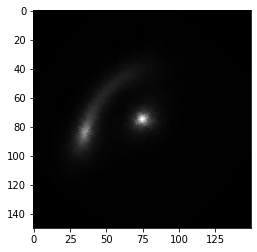

In [ ]:
show_example(*dataset[8000])

Label:  no_sub (0)


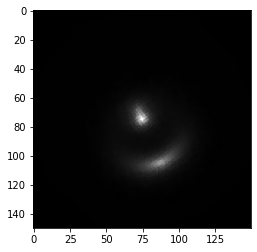

In [ ]:
show_example(*dataset[500])

## **Train, Validation and Test Sets**

In [ ]:
random_seed = 42
torch.manual_seed(random_seed);

In [ ]:
# 90-10 test train split
test_size = 1000

# 80-20 split of the training data into train and validation sets 
val_size = 1800

# Size of the train data
train_size = len(dataset) - val_size - test_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds), len(test_ds)

(7200, 1800, 1000)

In [ ]:
print(dataset.classes)

['no_sub', 'sub']


Lets now apply the transforms from above to our training and validation dataset.

In [ ]:
train_ds.dataset.transform = transforms

In [ ]:
val_ds.dataset.transform = transforms

## **DataLoader**

In [ ]:
from torch.utils.data.dataloader import DataLoader

batch_size = 64

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=0, pin_memory=True)

Let's look at batches of images from the dataset using the `make_grid` method from torchvision. Each time the following code is run, we get a different bach, since the sampler shuffles the indices before creating batches.

In [ ]:
def show_batch(dl, invert=True):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        data = 1-images if invert else images
        ax.imshow(make_grid(data, nrow=16).permute(1, 2, 0))
        break

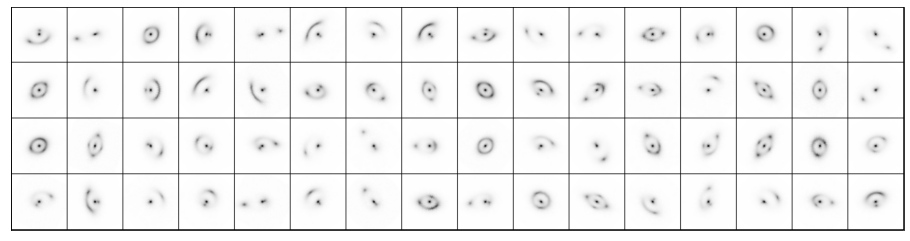

In [ ]:
show_batch(train_dl, invert=True)

# **Equivariant Neural Network**

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

## **Transfer Learning**

My aim in this project was to create an Equivariant Neural Network. It turns out that each neuron in a Dense Neural Network is just a slightly transformed version of some basic features that every other neuron on the network shares. That basically means that some layer will be responsible for learning the rotation of a particular feature while the other layer will be responsible for learning hue maps or scaled version of the same feature. This phenomenon is known as `Equivariance`. Inherently, all neural networks show some kind of equivariance during the training. 

To support this, I am using a pretrained `Resnet 34` which is a densly connected neural network with `skip connections`. I am using a `cross entropy loss` to train my model.

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch 
        out = self(images)                      
        loss = F.cross_entropy(out, targets)      
        return loss
    
    def validation_step(self, batch):
        images, targets = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, targets)  # Calculate loss
        acc = accuracy(out, targets)
        return {'val_loss': loss.detach(), 'val_acc': acc }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_acc = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()       # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
class Resnet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 2)
        
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

# **Training our Model**

I am varying the learning rate throughout the training process by making use of `OneCycleLR` from `torch.optim.lr_scheduler`, that will not only speed up my training but also find that sweet spot where model gives the best accuracy.

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = to_device(Resnet(), device)

Lets freeze the `ResNet()` layers. This will allow only the final layer to train on the model.

In [ ]:
model.freeze()

In [ ]:
epochs = 5
max_lr = 1e-3
opt_func = torch.optim.Adam

In [ ]:
history = fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                         opt_func=opt_func)


Epoch [0], last_lr: 0.0008, train_loss: 0.6269, val_loss: 0.7138, val_acc: 0.5885



Epoch [1], last_lr: 0.0010, train_loss: 0.5450, val_loss: 0.7982, val_acc: 0.5005



Epoch [2], last_lr: 0.0006, train_loss: 0.4323, val_loss: 0.5197, val_acc: 0.7661



Epoch [3], last_lr: 0.0002, train_loss: 0.3728, val_loss: 0.3651, val_acc: 0.9536



Epoch [4], last_lr: 0.0000, train_loss: 0.3490, val_loss: 0.3379, val_acc: 0.9771


In [ ]:
model.unfreeze()

In [ ]:
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, opt_func = opt_func)


Epoch [0], last_lr: 0.0008, train_loss: 0.3794, val_loss: 0.8135, val_acc: 0.4995



Epoch [1], last_lr: 0.0010, train_loss: 0.4366, val_loss: 0.7691, val_acc: 0.5328



Epoch [2], last_lr: 0.0006, train_loss: 0.3856, val_loss: 0.7118, val_acc: 0.5938



Epoch [3], last_lr: 0.0002, train_loss: 0.3636, val_loss: 0.3547, val_acc: 0.9578



Epoch [4], last_lr: 0.0000, train_loss: 0.3418, val_loss: 0.3325, val_acc: 0.9797


# **Evaluation and Prediction on the Test Dataset**

## **Evaluation of model on Train and Validation, Accuracy and Losses**

In [ ]:
def plot_accuracy(history):
  acc = [x['val_acc'] for x in history]
  plt.plot(acc, '-ro')
  plt.xlabel('No. of Epochs')
  plt.ylabel('Accuracy')
  plt.title('Validation Accuracy')

As you can see the validation accuracy just after `10 epochs` is quite high.

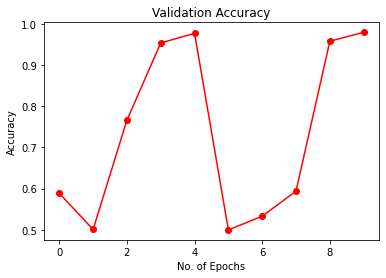

In [ ]:
plot_accuracy(history)

In [ ]:
def plot_losses(history):
  val_losses = [x['val_loss'] for x in history]
  train_losses = [x['train_loss'] for x in history]
  plt.plot(val_losses, '-gx')
  plt.plot(train_losses, '-rx')
  plt.xlabel('No. of Epochs')
  plt.ylabel('Losses')
  plt.legend(['Validation', 'Training'])
  plt.title('Train and Validation Losses')

The train and validation losses seem to converge at the `10th Epoch`. This shows a stable training process. If the model is trained for further more epochs a better result can be achieved.

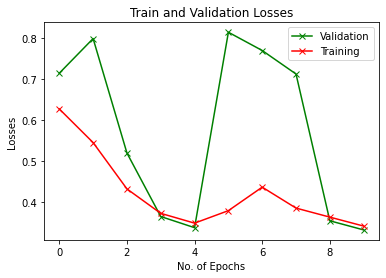

In [ ]:
plot_losses(history)

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

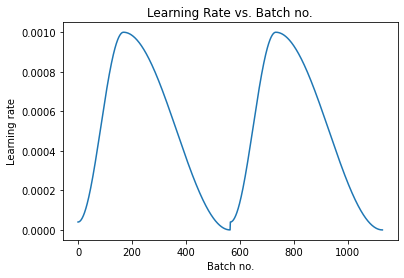

In [ ]:
plot_lrs(history)


## **Making Predictions on the Test Set**

It is time to see how good our model performs on the test dataset.

In [ ]:
def predict_image(img, model):
  xb = to_device(img.unsqueeze(0), device)
  # Get predictions from model
  yb = model(xb)
  # Pick index with highest probability
  _, preds  = torch.max(yb, dim=1)
  # Retrieve the class label
  return dataset.classes[preds[0].item()]


The model gives some satisfactory results. As all the predicted labels hold true.

Label: sub , Predicted: sub


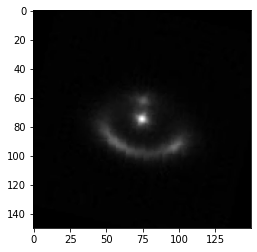

In [ ]:
img, label = test_ds[999]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: sub , Predicted: sub


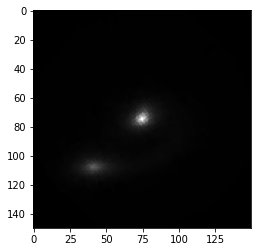

In [ ]:
img, label = test_ds[500]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

## **Computing the ROC Curve and AUC Score for the Test Data**

Lets now compute the AUC score and plot the ROC Curve to further evaluate our model.

In [ ]:
def compute_preds(model):
  y = []
  y_hat = []
  for img, label in test_ds:
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    y_hat.append(preds[0].cpu().item())
    y.append(label)
  return y, y_hat


In [ ]:
true_labels, predicted_labels = compute_preds(model)

In [ ]:
roc_auc = roc_auc_score(true_labels,predicted_labels)

In [ ]:
fpr, tpr, _ = roc_curve(true_labels, predicted_labels)

In [ ]:
def plot_roc_curve(fp, tp, auc):
  auc = float('{:.3f}'.format(auc))
  x = f'auc_score = {auc}'
  plt.plot(fp,tp,'-r', label=x)
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("ROC Curve AUC Score")
  plt.legend()



The model gives an `roc_auc_score` of `0.983` which is really impressive as I have only trained the model just for a few epochs. This performance is also depicted by the corresponding `ROC Curve`

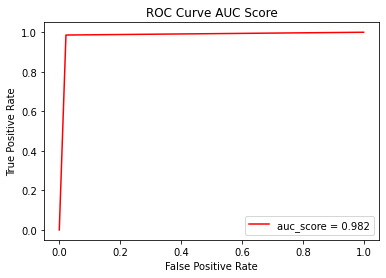

In [ ]:
plot_roc_curve(fpr, tpr, roc_auc)

In [ ]:
torch.save(model.state_dict(), os.path.join('/content/drive/MyDrive/equivariant model', 'Equivariant Model.pth'))